<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/images/IDSNlogo.png" width="300" alt="cognitiveclass.ai logo"  />
</center>

<h1 align="center"><font size="5">Loan Status Detection using Classification Algorithms</font></h1>


                         <h1 align="center"><font size="5">Loan Status Detection using Classification Algorithms</font></h1> 

Prediction of loan status using information like gender, age, education, etc. of a person using different Classification algorithms.

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Let's first load required libraries:


In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

### About dataset


This dataset is about past loans. The **Loan_train.csv** data set includes details of 346 customers whose loan are already paid off or defaulted. It includes following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
| Loan_status    | Whether a loan is paid off on in collection                                           |
| Principal      | Basic principal loan amount at the                                                    |
| Terms          | Origination terms which can be weekly (7 days), biweekly, and monthly payoff schedule |
| Effective_date | When the loan got originated and took effects                                         |
| Due_date       | Since it’s one-time payoff schedule, each loan has one single due date                |
| Age            | Age of applicant                                                                      |
| Education      | Education of applicant                                                                |
| Gender         | The gender of applicant                                                               |


Let's download the dataset


In [2]:
!wget -O loan_train.csv https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv

--2021-06-11 06:55:56--  https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/FinalModule_Coursera/data/loan_train.csv
Resolving cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)... 169.45.118.108
Connecting to cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud (cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud)|169.45.118.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0s      

2021-06-11 06:55:57 (187 MB/s) - ‘loan_train.csv’ saved [23101/23101]



### Load Data From CSV File


In [3]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [4]:
df.shape

(346, 10)

### Convert to date time object


In [5]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


# Data visualization and pre-processing


Let’s see how many of each class is in our data set


In [6]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection


Let's plot some columns to underestand data better:


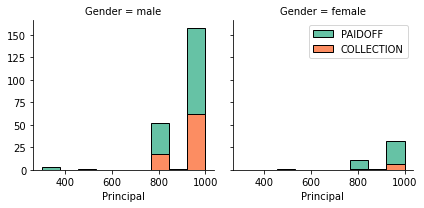

In [7]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set2", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec='k')

g.axes[-1].legend()
plt.show()

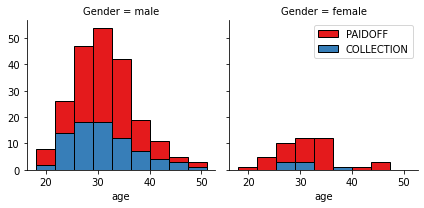

In [8]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing:  Feature selection/extraction


### Let's look at the day of the week people get the loan


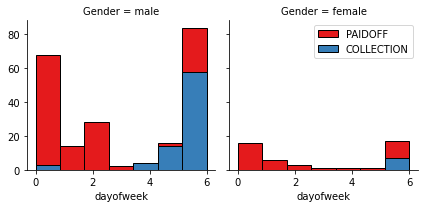

In [9]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 8)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()


We see that people who get the loan at the end of the week don't pay it off, so let's use Feature binarization to set a threshold value less than day 4


In [10]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values


Let's look at gender:


In [11]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan


Let's convert male to 0 and female to 1:


In [12]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


## One Hot Encoding

#### How about education?


In [13]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)

education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

#### Features before One Hot Encoding


In [14]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


#### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame


In [15]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()


,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


### Feature Selection


Let's define feature sets, X:


In [16]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?


In [17]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Normalize Data


Data Standardization give data zero mean and unit variance (technically should be done after train test split)


In [18]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

# Classification


Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model
You should use the following algorithm:

*   K Nearest Neighbor(KNN)
*   Decision Tree
*   Support Vector Machine
*   Logistic Regression

\__ Notice:\__

*   You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
*   You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
*   You should include the code of the algorithm in the following cells.


# K Nearest Neighbor(KNN)

Notice: You should find the best k to build the model with the best accuracy.\
**warning:** You should not use the **loan_test.csv** for finding the best k, however, you can split your train_loan.csv into train and test to find the best **k**.


In [19]:
# Doing train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=4)
print('Train set:', X_train.shape, y_train.shape)
print('Test set:', X_test.shape, y_test.shape)

Train set: (276, 8) (276,)
Test set: (70, 8) (70,)


For k= 1 , Test set accuracy:  0.6714285714285714
For k= 2 , Test set accuracy:  0.6571428571428571
For k= 3 , Test set accuracy:  0.7142857142857143
For k= 4 , Test set accuracy:  0.6857142857142857
For k= 5 , Test set accuracy:  0.7571428571428571
For k= 6 , Test set accuracy:  0.7142857142857143
For k= 7 , Test set accuracy:  0.7857142857142857
For k= 8 , Test set accuracy:  0.7571428571428571
For k= 9 , Test set accuracy:  0.7571428571428571
For k= 10 , Test set accuracy:  0.6714285714285714
For k= 11 , Test set accuracy:  0.7
For k= 12 , Test set accuracy:  0.7285714285714285
For k= 13 , Test set accuracy:  0.7
For k= 14 , Test set accuracy:  0.7
For k= 15 , Test set accuracy:  0.6857142857142857
For k= 16 , Test set accuracy:  0.7285714285714285
For k= 17 , Test set accuracy:  0.7285714285714285
For k= 18 , Test set accuracy:  0.7285714285714285
For k= 19 , Test set accuracy:  0.7


<function matplotlib.pyplot.show(*args, **kw)>

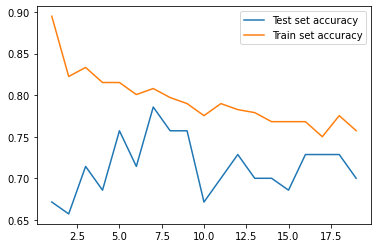

In [20]:
# Trying different values of K and calculating accuracy for each
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
test_data = []
train_data = []
for k in range(1,20):
    neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)
    yhat_kmeans= neigh.predict(X_test)
    test_data.append(metrics.accuracy_score(y_test, yhat_kmeans))
    train_data.append(metrics.accuracy_score(y_train, neigh.predict(X_train)))
    print('For k=',k,', Test set accuracy: ', metrics.accuracy_score(y_test, yhat_kmeans))

plt.plot(range(1,20),test_data, linestyle = '-', label = 'Test set accuracy')
plt.plot(range(1,20),train_data, linestyle = '-', label = 'Train set accuracy')
plt.legend()
plt.show

#### We can see that for k=7 in above graph, test set accuracy is highest then selected this value of k as final.

In [21]:
from sklearn.neighbors import KNeighborsClassifier
k = 7
# Training 
neigh = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)
neigh

KNeighborsClassifier(n_neighbors=7)

In [22]:
# Predicting and accuracy evaluation for k =7
yhat_kmeans= neigh.predict(X_test)

from sklearn import metrics
print('Train set accuracy: ', metrics.accuracy_score(y_train, neigh.predict(X_train)))
print('Test set Accuracy: ', metrics.accuracy_score(y_test, yhat_kmeans))

Train set accuracy:  0.8079710144927537
Test set Accuracy:  0.7857142857142857


# Decision Tree

For max_depth of tree =  1  ,DecisionTrees's Accuracy:  0.7857142857142857
For max_depth of tree =  2  ,DecisionTrees's Accuracy:  0.7857142857142857
For max_depth of tree =  3  ,DecisionTrees's Accuracy:  0.6142857142857143
For max_depth of tree =  4  ,DecisionTrees's Accuracy:  0.6142857142857143
For max_depth of tree =  5  ,DecisionTrees's Accuracy:  0.6428571428571429
For max_depth of tree =  6  ,DecisionTrees's Accuracy:  0.7714285714285715
For max_depth of tree =  7  ,DecisionTrees's Accuracy:  0.7571428571428571
For max_depth of tree =  8  ,DecisionTrees's Accuracy:  0.7571428571428571
For max_depth of tree =  9  ,DecisionTrees's Accuracy:  0.6571428571428571
For max_depth of tree =  10  ,DecisionTrees's Accuracy:  0.7
For max_depth of tree =  11  ,DecisionTrees's Accuracy:  0.6857142857142857
For max_depth of tree =  12  ,DecisionTrees's Accuracy:  0.7
For max_depth of tree =  13  ,DecisionTrees's Accuracy:  0.7
For max_depth of tree =  14  ,DecisionTrees's Accuracy:  0.7142857

<function matplotlib.pyplot.show(*args, **kw)>

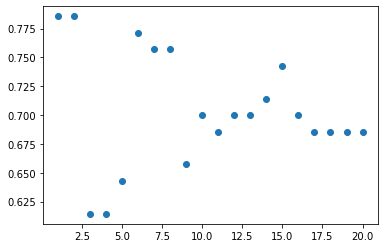

In [23]:
from sklearn.tree import DecisionTreeClassifier
test_data_acc_DT = []
max_depth_list = range(1,21)
for depth in max_depth_list:
    reqtree = DecisionTreeClassifier(criterion='entropy', max_depth = depth)
    reqtree.fit(X_train,y_train)

    predtree=reqtree.predict(X_test)
    test_data_acc_DT.append(metrics.accuracy_score(y_test, predtree ))
    print("For max_depth of tree = ",depth, " ,DecisionTrees's Accuracy: ",metrics.accuracy_score(y_test, predtree) )

plt.scatter(x = range(1,21), y = test_data_acc_DT, linestyle='-')
plt.show

#### We can see that for max_depth = 1 and 2, accuracy is highest, therefore taking max_depth = 2

In [24]:
reqtree = DecisionTreeClassifier(criterion='entropy', max_depth = 2)
reqtree.fit(X_train,y_train)

predtree=reqtree.predict(X_test)
print("DecisionTrees's Accuracy: ",metrics.accuracy_score(y_test, predtree) )


DecisionTrees's Accuracy:  0.7857142857142857


# Support Vector Machine


For kernel =  linear , Train set accuracy:  0.7427536231884058
                       Test set Accuracy:  0.7857142857142857
For kernel =  poly , Train set accuracy:  0.782608695652174
                       Test set Accuracy:  0.7714285714285715
For kernel =  rbf , Train set accuracy:  0.782608695652174
                       Test set Accuracy:  0.7428571428571429
For kernel =  sigmoid , Train set accuracy:  0.7101449275362319
                       Test set Accuracy:  0.7428571428571429


<function matplotlib.pyplot.show(*args, **kw)>

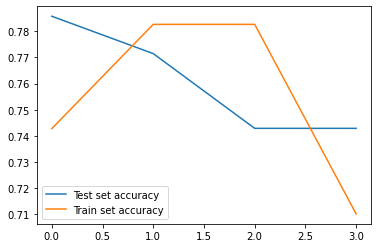

In [25]:
from sklearn import svm
test_data_acc_svm = []
train_data_acc_svm = []
kernel_list = ['linear', 'poly', 'rbf', 'sigmoid']
for kernel in kernel_list:
    clf = svm.SVC(kernel = kernel)
    clf.fit(X_train, y_train)
    yhat_svm = clf.predict(X_test)
    test_data_acc_svm.append(metrics.accuracy_score(y_test, yhat_svm))
    train_data_acc_svm.append(metrics.accuracy_score(y_train, clf.predict(X_train)))
    print('For kernel = ',kernel, ', Train set accuracy: ', metrics.accuracy_score(y_train, clf.predict(X_train)))
    print('                       Test set Accuracy: ', metrics.accuracy_score(y_test, yhat_svm))

plt.plot(range(0,len(kernel_list)),test_data_acc_svm, linestyle = '-', label = 'Test set accuracy')
plt.plot(range(0,len(kernel_list)),train_data_acc_svm, linestyle = '-', label = 'Train set accuracy')
plt.legend()
plt.show

#### From above result, we can see that for kernel = linear, we are getting the maximum accuracy, therefore, using it for kernel

In [26]:
clf = svm.SVC(kernel = 'linear')
clf.fit(X_train, y_train)

yhat_svm = clf.predict(X_test)
print('Train set accuracy: ', metrics.accuracy_score(y_train, clf.predict(X_train)))
print('Test set Accuracy: ', metrics.accuracy_score(y_test, yhat_svm))

Train set accuracy:  0.7427536231884058
Test set Accuracy:  0.7857142857142857


# Logistic Regression


In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
solver_list = ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']
for solverg in solver_list:
    LR = LogisticRegression(C=0.01, solver=solverg).fit(X_train, y_train)

    yhat_LR = LR.predict(X_test)

    print('For solver=',solverg,', \n   Train set accuracy: ', metrics.accuracy_score(y_train, LR.predict(X_train)))
    print('   Test set Accuracy: ', metrics.accuracy_score(y_test, yhat_LR),'\n')

For solver= liblinear , 
   Train set accuracy:  0.7572463768115942
   Test set Accuracy:  0.6857142857142857 

For solver= newton-cg , 
   Train set accuracy:  0.7427536231884058
   Test set Accuracy:  0.7857142857142857 

For solver= lbfgs , 
   Train set accuracy:  0.7427536231884058
   Test set Accuracy:  0.7857142857142857 

For solver= sag , 
   Train set accuracy:  0.7427536231884058
   Test set Accuracy:  0.7857142857142857 

For solver= saga , 
   Train set accuracy:  0.7427536231884058
   Test set Accuracy:  0.7857142857142857 



#### Apart from liblinear solver, other solvers have same accuracy, so taking newton-cg solver 

In [28]:
LR = LogisticRegression(C=0.01, solver='newton-cg').fit(X_train, y_train)

yhat_LR = LR.predict(X_test)

print('Train set accuracy: ', metrics.accuracy_score(y_train, LR.predict(X_train)))
print('Test set Accuracy: ', metrics.accuracy_score(y_test, yhat_LR))

Train set accuracy:  0.7427536231884058
Test set Accuracy:  0.7857142857142857


# Model Evaluation using Test set


In [29]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss


First, download and load the test set:


In [30]:
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2021-06-11 06:57:34--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2021-06-11 06:57:35 (70.6 MB/s) - ‘loan_test.csv’ saved [3642/3642]



### Load Test set for evaluation


In [31]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


### Pre-processing data 

In [32]:
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,1,1,PAIDOFF,1000,30,2016-09-08,2016-10-07,50,Bechalor,1,3,0
1,5,5,PAIDOFF,300,7,2016-09-09,2016-09-15,35,Master or Above,0,4,1
2,21,21,PAIDOFF,1000,30,2016-09-10,2016-10-09,43,High School or Below,1,5,1
3,24,24,PAIDOFF,1000,30,2016-09-10,2016-10-09,26,college,0,5,1
4,35,35,PAIDOFF,800,15,2016-09-11,2016-09-25,29,Bechalor,0,6,1


In [33]:
test_Feature = test_df[['Principal','terms','age','Gender','weekend']]
test_Feature = pd.concat([test_Feature,pd.get_dummies(test_df['education'])], axis=1)
test_Feature.drop(['Master or Above'], axis = 1,inplace=True)

test_Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,50,1,0,1,0,0
1,300,7,35,0,1,0,0,0
2,1000,30,43,1,1,0,1,0
3,1000,30,26,0,1,0,0,1
4,800,15,29,0,1,1,0,0


In [34]:
Xtest = test_Feature.values
Xtest = preprocessing.StandardScaler().fit(Xtest).transform(Xtest)
Xtest[0:5]

array([[ 0.49362588,  0.92844966,  3.05981865,  1.97714211, -1.30384048,
         2.39791576, -0.79772404, -0.86135677],
       [-3.56269116, -1.70427745,  0.53336288, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404, -0.86135677],
       [ 0.49362588,  0.92844966,  1.88080596,  1.97714211,  0.76696499,
        -0.41702883,  1.25356634, -0.86135677],
       [ 0.49362588,  0.92844966, -0.98251057, -0.50578054,  0.76696499,
        -0.41702883, -0.79772404,  1.16095912],
       [-0.66532184, -0.78854628, -0.47721942, -0.50578054,  0.76696499,
         2.39791576, -0.79772404, -0.86135677]])

In [35]:
# different values for result for test data by different classification algorithms
ytest = test_df['loan_status'].values
yhat_final_kmeans= neigh.predict(Xtest)
predtree_final= reqtree.predict(Xtest)
yhat_final_svm = clf.predict(Xtest)
yhat_final_LR = LR.predict(Xtest)
yhat_final_prob_LR = LR.predict_proba(Xtest)

In [36]:
jac_kmeans = jaccard_score(ytest, yhat_final_kmeans, pos_label = 'PAIDOFF')
jac_DT = jaccard_score(ytest, predtree_final, pos_label = 'PAIDOFF')
jac_SVM = jaccard_score(ytest, yhat_final_svm, pos_label = 'PAIDOFF')
jac_LR = jaccard_score(ytest, yhat_final_LR, pos_label = 'PAIDOFF')


In [37]:
f1_kmeans = f1_score(ytest, yhat_final_kmeans, average='weighted')
f1_DT = f1_score(ytest, predtree_final, average='weighted')
f1_SVM = f1_score(ytest, yhat_final_svm, average='weighted')
f1_LR = f1_score(ytest, yhat_final_LR, average='weighted')


In [38]:
logloss_lr = log_loss(ytest, yhat_final_prob_LR)
logloss_lr

0.5163659578353341

In [39]:
final_report = pd.DataFrame(columns = ['Algorithm','Jaccard','F1-score','LogLoss'], data = [['KNN', jac_kmeans, f1_kmeans, 'NA'], ['Decision Tree', jac_DT, f1_DT, 'NA'], ['SVM', jac_SVM, f1_SVM, 'NA'], ['LogisticRegression', jac_LR, f1_LR, logloss_lr]])
final_report

,Algorithm,Jaccard,F1-score,LogLoss
0,KNN,0.653846,0.632840,NA
1,Decision Tree,0.740741,0.630418,NA
2,SVM,0.740741,0.630418,NA
3,LogisticRegression,0.740741,0.630418,0.516366


In [40]:
final_report.set_index('Algorithm', inplace=True)

In [41]:
final_report

,Jaccard,F1-score,LogLoss
Algorithm,,,
KNN,0.653846,0.632840,NA
Decision Tree,0.740741,0.630418,NA
SVM,0.740741,0.630418,NA
LogisticRegression,0.740741,0.630418,0.516366
